# 平均合意プロトコルにおける収束加速

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux
using LightGraphs

### 準備 (グローバル定数の設定)

この例ではKarateグラフを例として利用する。

In [2]:
n = 34
g = smallgraph("karate")
L = Matrix(laplacian_matrix(g)) + 1e-12*I 
eig = eigvals(L)
lmin = eig[2]
lmax = eig[n]
η_opt = 2.0/(lmin + lmax)

K = 200
num_itr = 75
adam_lr = 5e-4
max_inner = 50

50

### ミニバッチ生成関数

ミニバッチ生成関数の返り値は、ノード初期値とその平均値ベクトルからなるミニバッチとなる。

In [3]:
function mini_batch(K)
    x0 = randn(n, K)
    r = zeros(n, K)
    c = sum(x0, dims=1)
    for j in 1:K
        r[:,j] = c[j]*ones(n)/n
    end
    return x0, r
end

mini_batch (generic function with 1 method)

### 固定ステップサイズの平均合意プロトコル (普通のコンセンサスプロトコル)

In [4]:
function consensus(max_itr, x0)
    x = x0
    for i in 1:max_itr
        x = (I - η_opt*L)*x
    end
    return x
end

function comp_mse(max_itr)
    x0, c = mini_batch(K)
    x̂ = consensus(max_itr, x0)
    return norm(c-x̂)^2/K
end

comp_mse (generic function with 1 method)

### 合意状態からの誤差(MSE)のプロット

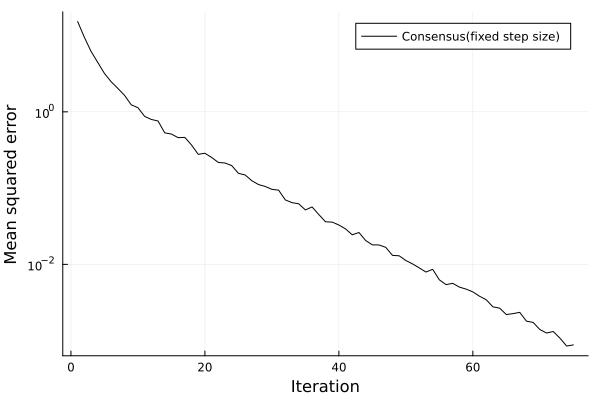

In [5]:
consensus_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, consensus_mse, lw=1, yscale=:log10, label="Consensus(fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-consensus反復の定義

In [6]:
function DU_consensus(max_itr, x0, η)
    x = x0
    for i in 1:max_itr
        x = (I - η[i]*L)*x
    end
    return x
end

DU_consensus (generic function with 1 method)

### 損失関数の定義

In [7]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end 

loss (generic function with 1 method)

### 訓練関数の定義

In [8]:
function train(opt, η)
    ps = Flux.params(η) 
    for itr in 1:num_itr
        for i in 1:max_inner
            y, x_opt = mini_batch(K)
            gs = Flux.gradient(ps) do
                x_hat = DU_consensus(itr, y, η)
                loss(x_opt, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        y, x_opt = mini_batch(K)
        x_est = DU_consensus(itr, y, η)
        println(itr, " ", loss(x_opt, x_est))
    end
end

train (generic function with 1 method)

In [9]:
function comp_mse_DU_consensus(max_itr, η)
    x0, c = mini_batch(K)
    x̂ = DU_consensus(max_itr, x0, η)
    return loss(c, x̂)
end

comp_mse_DU_consensus (generic function with 1 method)

### 学習過程

1 26.522302935332206
2 17.604415489367298
3 11.354814126729025
4 7.186587890473168
5 4.729529199875149
6 2.901886689597839
7 1.9320695955973255
8 1.2194810519176615
9 0.9345193220066713
10 0.7284896469695141
11 0.5521126845749275
12 0.4285498820372813
13 0.3442813088774791
14 0.27543983352500756
15 0.21821235568174457
16 0.16554719151948624
17 0.1335341005186844
18 0.11920064013376372
19 0.08770010958446744
20 0.07001819793287022
21 0.0611225973248307
22 0.05183949753606296
23 0.037198072349381314
24 0.033888736243943104
25 0.026647620469285753
26 0.01862408422853127
27 0.01805474879475326
28 0.011284175934998147
29 0.00878677112024491
30 0.012731533390952508
31 0.010251224443089872
32 0.008090327281725325
33 0.005805688646795556
34 0.005060864629832199
35 0.004003147600591487
36 0.0038873668273753355
37 0.003050831102850333
38 0.002722930289160262
39 0.002355085307325951
40 0.0017805253378769623
41 0.001549104819013239
42 0.0011805537704351397
43 0.0011540362666324444
44 0.00096253985

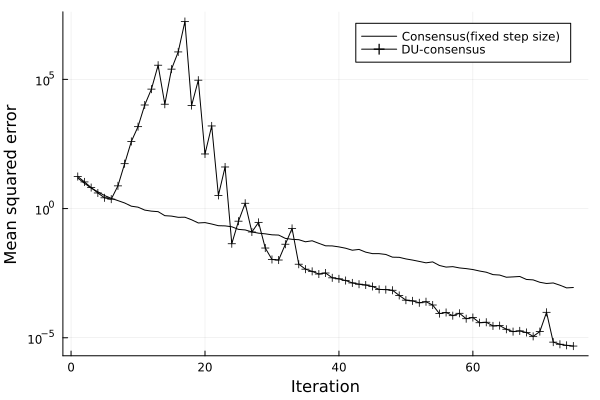

In [10]:
η_train = zeros(num_itr)
opt = Flux.ADAM(adam_lr)
train(opt, η_train)
DU_consensus_mse =[comp_mse_DU_consensus(i, η_train) for i in 1:num_itr]
plot!(1:num_itr, DU_consensus_mse, lw=1, label="DU-consensus", color=:black, marker=:+)

In [11]:
savefig("DU-consensus.pdf")